In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as la
import pywt
from numpy import fft
from scipy import signal
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

In [2]:
DF = pd.read_csv('4_Chest_sweater.txt',sep='\t')
sample_f = DF['Log Freq'][0]
DF['Time'] = np.arange(0, len(DF['AccX']) )/sample_f    #changed freq
DF

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk,Time
0,5,100,1555414552,687.836,380.823,580.354,-7.926829,8.048780,0.975610,-592,122,-113,0.788006,0.002899,-0.432874,-0.437788,0.00
1,5,100,1555414552,-812.703,-108.946,726.876,-11.707320,-81.829270,8.780488,125,60,-128,0.183978,-0.428877,0.002594,0.884426,0.01
2,5,100,1555414552,-812.520,-108.824,733.952,-37.073170,-145.487800,14.756100,123,59,-136,0.128994,-0.427229,0.000702,0.894894,0.02
3,5,100,1555414552,-787.144,-45.628,616.954,-56.341460,-174.634200,23.048780,118,58,-145,0.113618,-0.421033,-0.001770,0.899899,0.03
4,5,100,1555414552,-800.259,-137.433,411.689,-1.097561,37.073170,1.341463,113,57,-157,0.107202,-0.424787,-0.001251,0.898923,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14933,5,100,1555415471,-890.722,-81.008,446.764,-2.682927,2.926829,0.365854,144,47,-50,0.017279,0.534410,0.040437,-0.844081,149.33
14934,5,100,1555415471,-885.964,-76.006,459.025,-3.902439,3.292683,0.365854,146,45,-51,0.016416,0.535050,0.041231,-0.843654,149.34
14935,5,100,1555415471,-879.681,-77.714,475.068,-3.048780,2.804878,0.365854,144,46,-54,0.015920,0.534349,0.041780,-0.844081,149.35
14936,5,100,1555415471,-894.992,-76.311,502.701,0.121951,1.463415,0.609756,144,45,-53,0.015192,0.531663,0.041749,-0.845790,149.36


In [3]:
a = 2500
b = 12500
df = DF.iloc[a:b+1]    
df = df.drop(['Log Mode', 'Log Freq', 'Timestamp','qw', 'qi', 'qj', 'qk'], axis=1)  
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
2500,-817.583,-97.844,591.151,-4.512195,3.780488,0.121951,128,53,-113,25.00
2501,-804.590,-89.182,605.913,-2.317073,3.292683,-0.243902,127,51,-113,25.01
2502,-818.559,-90.646,607.011,-1.585366,0.000000,0.121951,126,50,-112,25.02
2503,-805.810,-91.439,603.290,-2.682927,0.731707,0.609756,127,50,-114,25.03
2504,-810.629,-100.040,582.184,-1.097561,2.926829,0.487805,128,51,-112,25.04
...,...,...,...,...,...,...,...,...,...,...
12496,-799.466,-77.958,602.192,-2.073171,0.487805,0.731707,123,47,-117,124.96
12497,-795.135,-78.141,615.734,-2.439024,0.121951,0.365854,121,46,-116,124.97
12498,-795.074,-81.923,623.115,-2.195122,0.487805,0.121951,121,47,-116,124.98
12499,-798.978,-84.241,632.814,-2.317073,1.219512,0.243902,124,48,-118,124.99


In [4]:
gyro_off = np.array([-2.804399, 1.793105, 0.3411708])
acc_cal = np.array([[1.002982, 9.415505E-05, 0.004346743],
                    [9.04459E-05, 1.002731, -0.001444198], 
                    [0.004346536, -0.001444751,	1.030587]])
acc_off = np.array([3.602701, -20.96658, 54.97186])
magn_cal=np.array([[1.013437, -0.04728858, -0.001861475], 
                    [-0.04728862, 1.004832, 0.008222118],    
                    [-0.001861605, 0.008221965, 0.9439077]])
magn_off=np.array([-150.4098, 74.62431, 630.9805])

In [5]:
df[['GyroX','GyroY','GyroZ']]=df[['GyroX','GyroY','GyroZ']]+gyro_off.T
df[['AccX','AccY','AccZ']]=np.dot(df[['AccX','AccY','AccZ']],acc_cal.T)+acc_off.T
df[['MagnX','MagnY','MagnZ']]=np.dot(df[['MagnX','MagnY','MagnZ']],magn_cal.T)+magn_off.T
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
2500,-813.857963,-120.005478,660.792102,-7.316594,5.573593,0.463122,-22.985812,120.898363,524.516409,25.00
2501,-800.761235,-111.339966,676.049587,-5.121472,5.085788,0.097268,-23.904672,118.935988,524.501826,25.01
2502,-814.767256,-112.810814,677.122570,-4.389765,1.793105,0.463122,-24.872682,117.986667,525.439374,25.02
2503,-801.996487,-113.599452,673.344316,-5.487326,2.524812,0.950927,-23.855522,117.922934,523.549697,25.03
2504,-806.922410,-122.193896,651.584227,-3.901960,4.719934,0.828976,-22.893096,118.896921,525.443872,25.04
...,...,...,...,...,...,...,...,...,...,...
12496,-795.637073,-100.079476,672.220829,-4.877570,2.280910,1.072878,-27.761820,115.072926,520.700754,124.96
12497,-791.234311,-100.282142,686.196127,-5.243423,1.915056,0.707024,-29.743267,114.170893,521.640163,124.97
12498,-791.141402,-104.085124,693.808619,-4.999521,2.280910,0.463122,-29.790555,115.175725,521.648385,124.98
12499,-795.015103,-106.423815,703.790662,-5.121472,3.012617,0.585073,-26.793810,116.022247,519.763207,124.99


In [6]:
stat_df = pd.DataFrame({
    'mean'  : df.mean(),
    'median': df.median(),
    'variance': df.var(),
    'standard deviation': df.std(),
    '25% percentile' : df.quantile(q=0.25),
    '75% percentile': df.quantile(q=0.75)
    }).T
stat_df.drop(['Time'], axis=1)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
mean,-781.303663,-93.000182,709.985107,-5.630494,3.304734,0.621387,-34.094530,110.521105,511.925778
median,-779.137681,-93.058513,712.570307,-5.609277,3.256520,0.585073,-34.786252,110.381876,511.194350
variance,164.959067,158.748301,410.642127,0.634556,0.836360,0.057051,16.201442,16.214815,29.094141
standard deviation,12.843639,12.599536,20.264307,0.796590,0.914527,0.238854,4.025101,4.026762,5.393898
25% percentile,-789.595916,-102.844146,697.208329,-6.097082,2.768715,0.463122,-37.355539,107.369424,508.366350
75% percentile,-771.860406,-82.925857,724.270962,-5.121472,3.866276,0.828976,-31.653226,113.312061,515.018227


In [7]:
dfc = df - stat_df.iloc[0]
dfc['Time'] = df['Time']
dfc

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
2500,-32.554300,-27.005296,-49.193005,-1.686100,2.268859,-0.158265,11.108718,10.377258,12.590631,25.00
2501,-19.457573,-18.339784,-33.935520,0.509022,1.781054,-0.524118,10.189858,8.414883,12.576049,25.01
2502,-33.463593,-19.810632,-32.862537,1.240729,-1.511629,-0.158265,9.221848,7.465562,13.513596,25.02
2503,-20.692825,-20.599270,-36.640791,0.143168,-0.779922,0.329540,10.239008,7.401829,11.623919,25.03
2504,-25.618747,-29.193714,-58.400880,1.728534,1.415200,0.207589,11.201434,8.375816,13.518095,25.04
...,...,...,...,...,...,...,...,...,...,...
12496,-14.333410,-7.079294,-37.764278,0.752924,-1.023824,0.451491,6.332710,4.551821,8.774977,124.96
12497,-9.930649,-7.281960,-23.788980,0.387071,-1.389678,0.085638,4.351263,3.649788,9.714385,124.97
12498,-9.837740,-11.084942,-16.176488,0.630973,-1.023824,-0.158265,4.303975,4.654620,9.722607,124.98
12499,-13.711441,-13.423633,-6.194444,0.509022,-0.292117,-0.036313,7.300720,5.501142,7.837429,124.99


In [8]:
Sig = dfc.values[:,:-1].T
n_Sig = np.zeros_like(Sig)
for i in range(Sig.shape[0]):
    fou = fft.rfft(Sig[i])
    freq = fft.rfftfreq(len(Sig[i]), 1/sample_f)
    fou[freq < 0.25] = 0
    n_Sig[i] = fft.irfft(fou, len(Sig[i]))

dfn = pd.DataFrame(n_Sig.T, columns = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ'])
dfn

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,-6.383849,-6.371186,-10.102921,-1.743882,2.662728,-0.163529,1.916337,3.268818,-0.289256
1,6.720235,2.362344,5.195501,0.448941,2.177867,-0.529972,0.986550,1.284437,-0.304534
2,-7.278792,0.959312,6.308875,1.178349,-1.111895,-0.164704,0.007723,0.313199,0.632482
3,5.498607,0.238279,2.570462,0.078489,-0.377289,0.322518,1.014180,0.227640,-1.257563
4,0.578950,-8.288777,-19.150340,1.661557,1.820709,0.199987,1.966016,1.179894,0.636411
...,...,...,...,...,...,...,...,...,...
9996,11.794876,13.211919,1.113142,0.706634,-0.645021,0.449223,-2.803394,-2.445345,-4.098990
9997,16.206783,13.078184,15.132020,0.338483,-1.007816,0.082763,-4.796311,-3.369792,-3.161089
9998,16.308483,9.343962,22.787574,0.580087,-0.638926,-0.161741,-4.854963,-2.387296,-3.154214
9999,12.443217,7.073858,32.812155,0.455838,0.095794,-0.040389,-1.869474,-1.563032,-5.040576


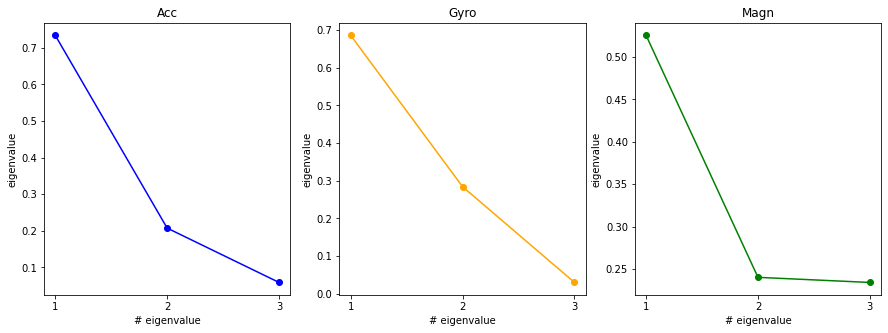

In [9]:
N = dfn.shape[0]

#Acc
U_acc,D_diag_acc,_=la.svd(dfn[['AccX','AccY','AccZ']].T)
avl_acc = np.real_if_close(D_diag_acc)**2/(N-1)
avl_acc_n = avl_acc/avl_acc.sum()

#Gyro
U_gyro,D_diag_gyro,_=la.svd(dfn[['GyroX','GyroY','GyroZ']].T)
avl_gyro = np.real_if_close(D_diag_gyro)**2/(N-1)
avl_gyro_n = avl_gyro/avl_gyro.sum()

#Magn
U_magn,D_diag_magn,_=la.svd(dfn[['MagnX','MagnY','MagnZ']].T)
avl_magn = np.real_if_close(D_diag_magn)**2/(N-1)
avl_magn_n = avl_magn/avl_magn.sum()

#Plot
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax1.plot(np.arange(U_acc.shape[0])+1, avl_acc_n, color = 'blue', marker = 'o')
ax1.set_title('Acc')
ax1.set_xlabel('# eigenvalue')
ax1.set_ylabel('eigenvalue')
ax1.xaxis.set_major_locator(MultipleLocator(1.000))
ax2.plot(np.arange(U_gyro.shape[0])+1, avl_gyro_n, color = 'orange', marker = 'o')
ax2.set_title('Gyro')
ax2.set_xlabel('# eigenvalue')
ax2.set_ylabel('eigenvalue')
ax2.xaxis.set_major_locator(MultipleLocator(1.000))
ax3.plot(np.arange(U_magn.shape[0])+1, avl_magn_n, color = 'green', marker = 'o')
ax3.set_title('Magn')
ax3.set_xlabel('# eigenvalue')
ax3.set_ylabel('eigenvalue')
ax3.xaxis.set_major_locator(MultipleLocator(1.000))
plt.show()

In [10]:
rot=np.dot(dfn[['AccX','AccY','AccZ']],U_acc)
rot1=np.dot(dfn[['GyroX','GyroY','GyroZ']],U_gyro)
rot2=np.dot(dfn[['MagnX','MagnY','MagnZ']],U_magn)
dfr=pd.DataFrame({'acc_PCA1': rot[:,0], 'acc_PCA2': rot[:,1],'acc_PCA3': rot[:,2],
                  'gyro_PCA1': rot1[:,0], 'gyro_PCA2': rot1[:,1],'gyro_PCA3': rot1[:,2],
                  'magn_PCA1': rot2[:,0], 'magn_PCA2': rot2[:,1],'magn_PCA3': rot2[:,2]})
dfr['Time']=dfc['Time'].values
dfr

,acc_PCA1,acc_PCA2,acc_PCA3,gyro_PCA1,gyro_PCA2,gyro_PCA3,magn_PCA1,magn_PCA2,magn_PCA3,Time
0,10.664011,-7.041772,4.484068,3.157144,-0.346552,0.265186,-0.658815,-1.543251,-3.409623,25.00
1,-5.482948,6.855074,-0.825042,1.453471,-1.733718,-0.327360,-0.138183,-0.462393,-1.575721,25.01
2,-6.221353,-7.209001,-1.740135,-1.570778,-0.204229,-0.378008,-0.647486,-0.280974,0.001333,25.02
3,-2.686115,5.377565,0.874825,-0.381294,0.181060,0.272686,0.903838,0.460292,-1.277910,25.03
4,19.692419,-0.218986,6.923526,0.317955,-2.438709,0.259520,-1.282276,0.143595,-1.999384,25.04
...,...,...,...,...,...,...,...,...,...,...
9996,-2.306138,13.801430,-10.913992,-0.998965,-0.133054,0.318667,4.978076,0.569336,2.352670,124.96
9997,-16.359502,17.687418,-9.066348,-0.995067,0.379569,-0.053689,4.729664,0.126866,4.686871,124.97
9998,-23.720855,16.922153,-4.848871,-0.832440,-0.042839,-0.275856,4.609648,-0.708013,4.179567,124.98
9999,-33.475707,12.419180,-2.579074,-0.208651,-0.413071,-0.066585,5.515279,0.434666,0.859170,124.99


In [39]:
a = dfr['acc_PCA1']
g = dfr['gyro_PCA1']
m = dfr['magn_PCA1']
t = dfr['Time']

(60.0, 64.0)

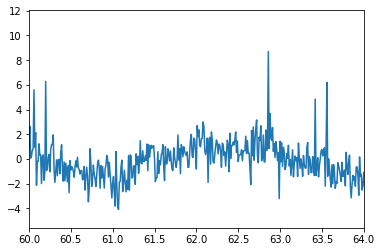

In [13]:
plt.plot(t, m)
plt.xlim(60, 64)

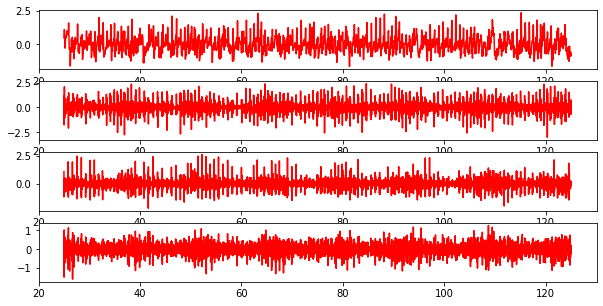

In [77]:
n = 3
coeffs = pywt.wavedec(g, 'bior5.5', level = n)
sigs = np.zeros((n+1,len(t)+1))
for i in range(n+1):
    ca = coeffs.copy()
    for j in range(n+1):
        if j != i: 
            ca[j] = np.zeros_like(ca[j])
    sigs[i] = pywt.waverec(ca, 'bior5.5')

ax = []
fig, ax = plt.subplots(nrows = n+1, ncols = 1, figsize = (10, 5))
for i in range(n+1):
    ax[i].plot(t, sigs[i][:-1], color = 'red')

(30.0, 40.0)

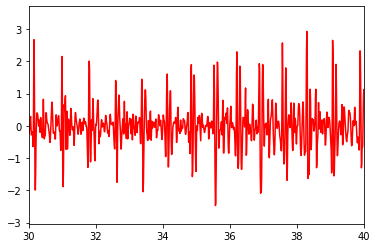

In [78]:
ca = coeffs.copy()
for j in range(n+1):
    if (j!=1) & (j!=2): 
        ca[j] = np.zeros_like(ca[j])
sigg = pywt.waverec(ca, 'bior5.5')
plt.plot(t, (sigg[:-1]), color = 'red')
plt.xlim(30, 40)

(30.0, 40.0)

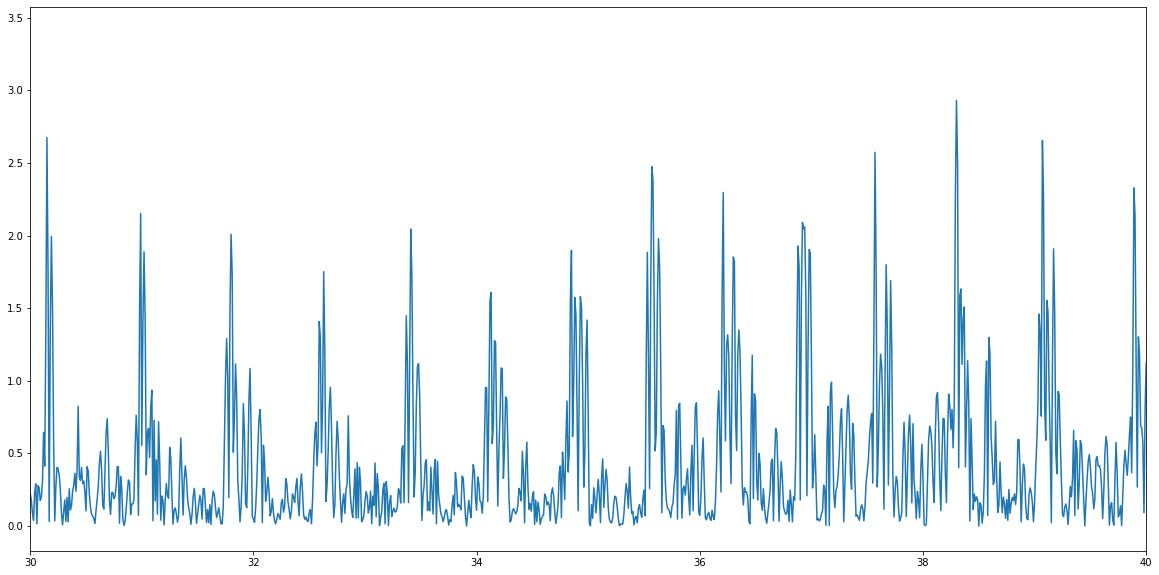

In [79]:
SIG = np.abs(sigg)
plt.figure(figsize=(20,10))
plt.plot(t, SIG[:-1])
plt.xlim(30, 40)

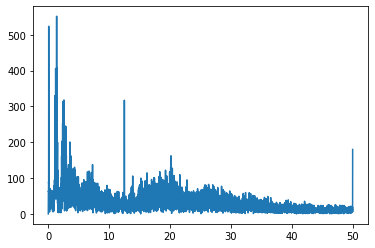

In [80]:
FFT = fft.rfft(SIG-SIG.mean())
freq = fft.rfftfreq(len(SIG), 1/sample_f)
plt.plot(freq, np.abs(FFT))

(30.0, 60.0)

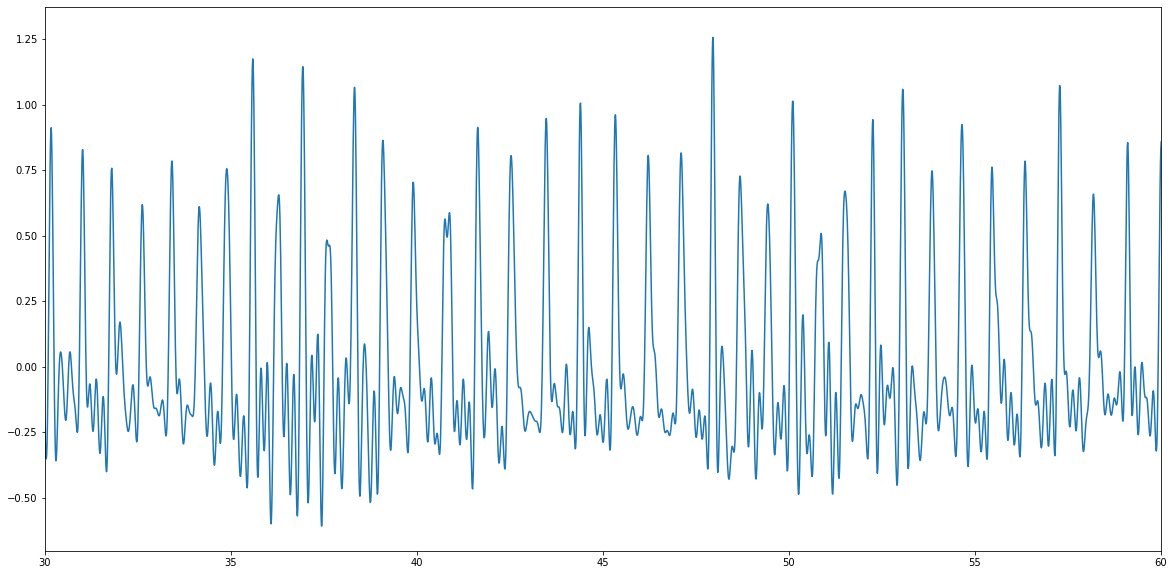

In [96]:
filt = np.zeros_like(freq)
f1 = 0.66
f2 = 6
filt[(freq>f1) & (freq<f2)] = 1
for i in range(len(freq)):
    if freq[i] > f1:
        filt[i-1] = 2/3
        filt[i-2] = 1/3
        break
for i in range(len(freq)):
    if freq[i] > f2:
        filt[i] = 2/3
        filt[i+1] = 1/3
        break

new_FFT = FFT*filt
new_SIG = fft.irfft(new_FFT, len(SIG))
plt.figure(figsize=(20,10))
plt.plot(t, new_SIG[:-1])
plt.xlim(30, 60)

(30.0, 40.0)

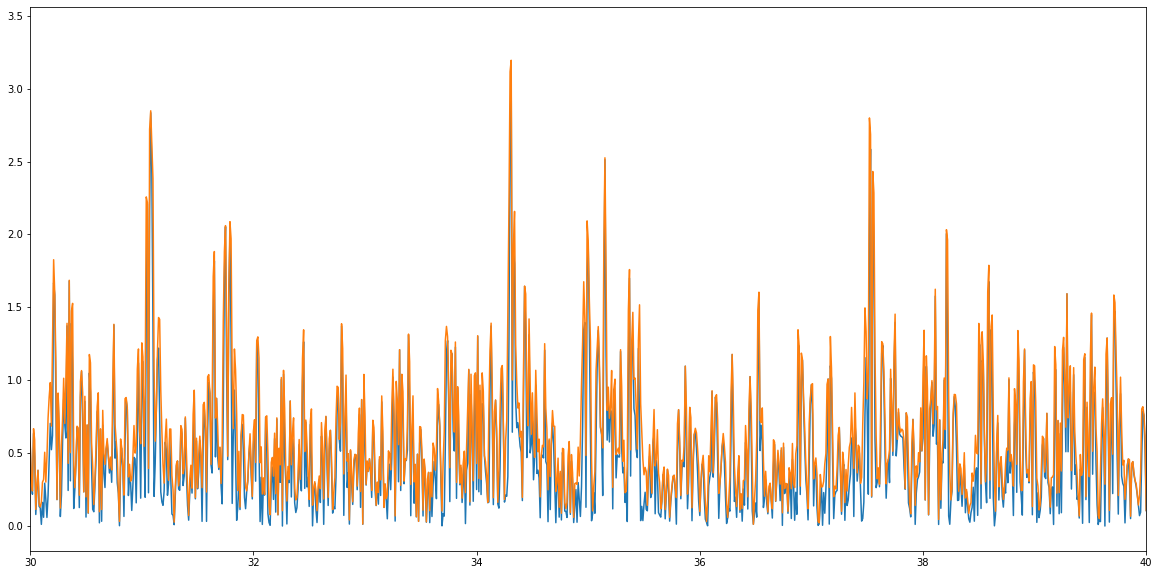

In [46]:
SIG_h = signal.hilbert(SIG)
plt.figure(figsize=(20,10))
plt.plot(t, SIG[:-1])
plt.plot(t, np.abs(SIG_h[:-1]))
plt.xlim(30, 40)


(40.0, 60.0)

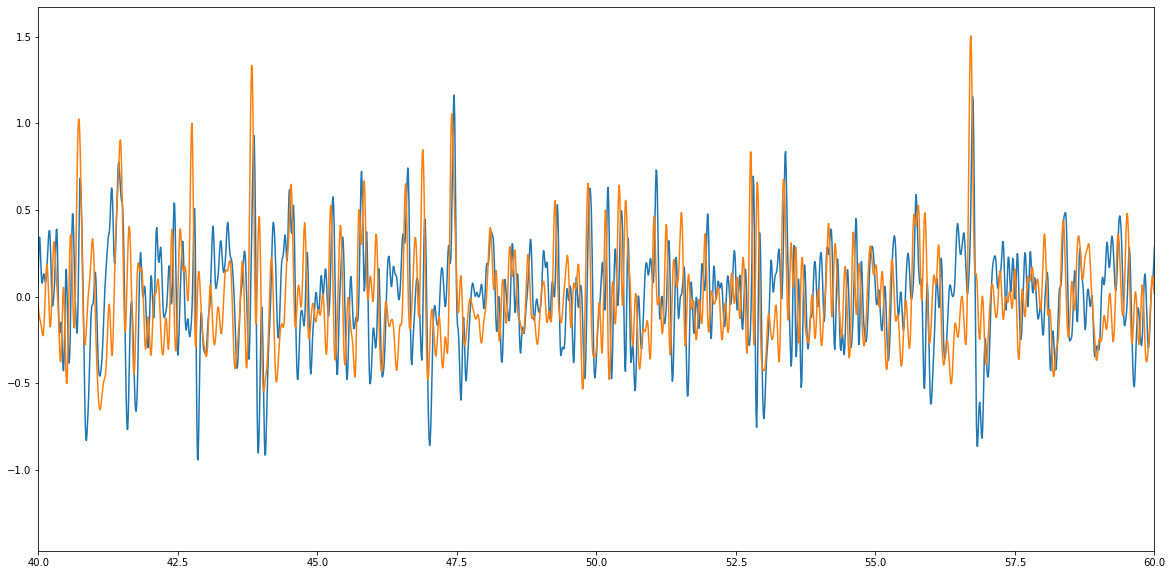

In [76]:
sos = signal.butter(4, Wn=[0.67/50, 10/50], btype='bandpass', output = 'sos')
filtered_data_butterworth = signal.sosfilt(sos, np.abs(SIG_h))
filtered_data_butterworth_2 = signal.sosfiltfilt(sos, np.abs(SIG_h))
plt.figure(figsize=(20,10))
plt.plot(t, filtered_data_butterworth[:-1])
plt.plot(t, filtered_data_butterworth_2[:-1])
plt.xlim(40, 60)

(0.0, 2.0)

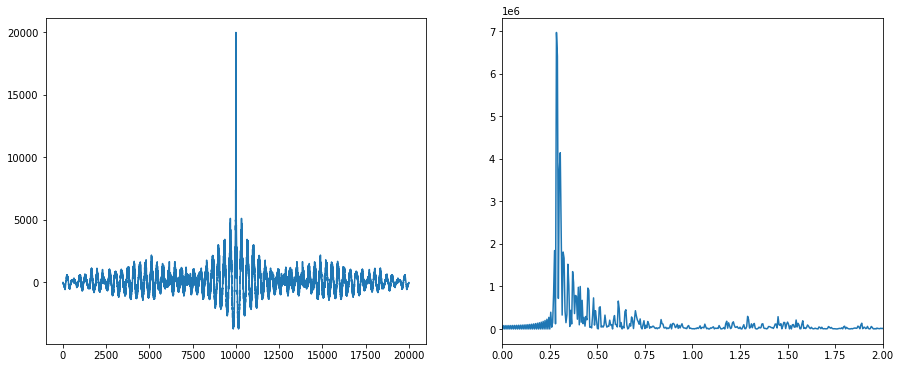

In [37]:
autocorr = signal.fftconvolve(m, m[::-1], mode='full')
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 6))
ax1.plot(autocorr)
tras = fft.rfft(autocorr)
freq = fft.rfftfreq(autocorr.size, d = 1/100)
ax2.plot(freq, np.abs(tras))
ax2.set_xlim(0, 2)

(0.0, 2.0)

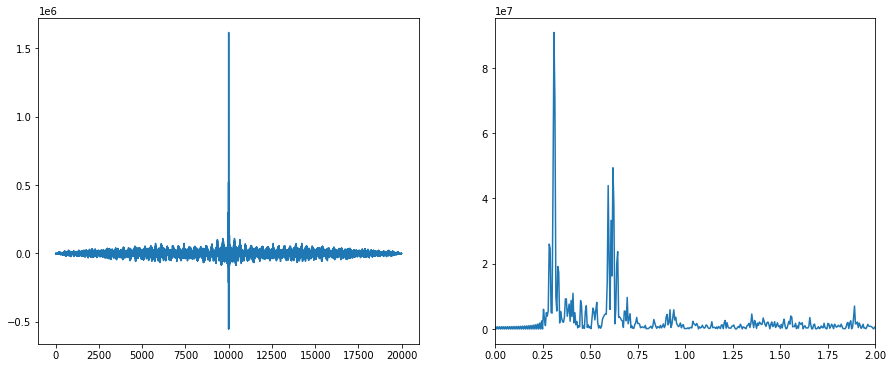

In [40]:
autocorr = signal.fftconvolve(a, a[::-1], mode='full')
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 6))
ax1.plot(autocorr)
tras = fft.rfft(autocorr)
freq = fft.rfftfreq(autocorr.size, d = 1/100)
ax2.plot(freq, np.abs(tras))
ax2.set_xlim(0, 2)

(0.0, 2.0)

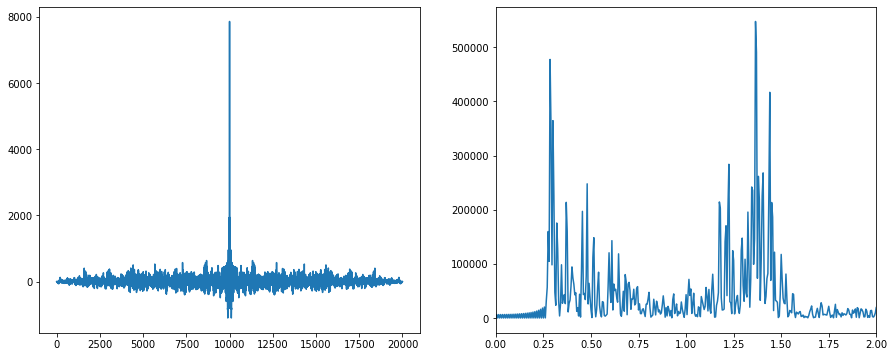

In [42]:
autocorr = signal.fftconvolve(g, g[::-1], mode='full')
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 6))
ax1.plot(autocorr)
tras = fft.rfft(autocorr)
freq = fft.rfftfreq(autocorr.size, d = 1/100)
ax2.plot(freq, np.abs(tras))
ax2.set_xlim(0, 2)